In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import os
from os.path import join
import torch as th
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from circuit_toolkit.plot_utils import show_imgrid
from circuit_toolkit.layer_hook_utils import featureFetcher
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from circuit_toolkit.plot_utils import saveallforms
from core.data_utils import load_neural_data, load_from_hdf5, parse_image_fullpaths
from core.model_load_utils import load_model_transform
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [8]:
from neural_regress.sklearn_torchify_lib import LinearLayer_from_sklearn

In [ ]:

subject_id = "red_20241212-20241220"
modelname = "clipag_vitb32"
model_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/{subject_id}/model_outputs/"
Xtransform_path = join(model_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl")
readout_path = join(model_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")
meta_path = join(model_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
csv_path = join(model_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv")
model, transforms_pipeline = load_model_transform("clipag_vitb32")
pred_D2_dict = pkl.load(open(meta_path, "rb"))
result_df_lyrswp = pd.read_csv(csv_path)
Xtfmer_lyrswp = pkl.load(open(Xtransform_path, "rb"))
fit_models_lyrswp = th.load(readout_path)

In [15]:
device = "cuda"
key = ('.transformer.resblocks.ResidualAttentionBlock9_clstoken', 'RidgeCV')
layer_name = '.transformer.resblocks.ResidualAttentionBlock9'
readout = LinearLayer_from_sklearn(fit_models_lyrswp[key]).to(device)
Xtransform = Xtfmer_lyrswp[key[0]]
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name,  ingraph=True, store_device=device)

In [16]:
def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
    
check_gradient(population_prediction)

torch.Size([1, 64])


In [17]:
from horama import maco, plot_maco

torch.Size([])


100%|██████████| 500/500 [00:08<00:00, 61.90it/s]


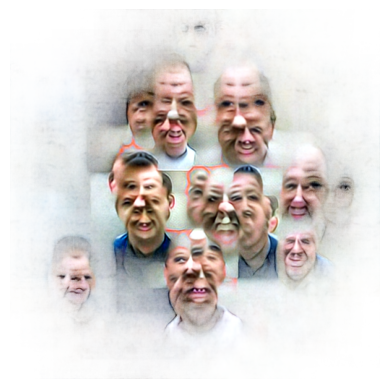

In [22]:
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, 44].mean()

maco_hyperparams = dict(total_steps=500, learning_rate=1.0, image_size=512,
        model_input_size=224, noise=0.50, values_range=(-2.5, 2.5),
        crops_per_iteration=6, box_size=(0.20, 0.25),)
check_gradient(objective)
# Optimization part 1: MACO
image1, alpha1 = maco(objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)

torch.Size([])


100%|██████████| 500/500 [00:07<00:00, 64.59it/s]


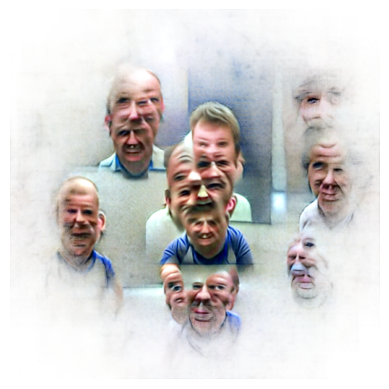

In [23]:
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, :].mean()

maco_hyperparams = dict(total_steps=500, learning_rate=1.0, image_size=512,
        model_input_size=224, noise=0.50, values_range=(-2.5, 2.5),
        crops_per_iteration=6, box_size=(0.20, 0.25),)

check_gradient(objective)
# Optimization part 1: MACO
image1, alpha1 = maco(objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)

### Export Models

In [27]:
# figdir = join(dataroot, "model_outputs", subject_id, )
subject_id = "red_20241212-20241220"
modelname = "clipag_vitb32"
model_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/{subject_id}/model_outputs/"
csv_path = join(model_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv")
model, transforms_pipeline = load_model_transform("clipag_vitb32")
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"
os.makedirs(outputdir, exist_ok=True)

In [24]:
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"
data_path = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
subject_id = 'red_20241212-20241220'
data_dict = load_neural_data(data_path, subject_id, None)
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']

In [28]:
for modelname in ["clipag_vitb32"]:
    Xtransform_path = join(model_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl")
    readout_path = join(model_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")
    meta_path = join(model_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    fit_models_lyrswp_RidgeCV = th.load(readout_path)
    Xtfmer_lyrswp_RidgeCV = pkl.load(open(Xtransform_path, "rb"))
    pred_data = pkl.load(open(meta_path, "rb"))
    keys = [ ('.transformer.resblocks.ResidualAttentionBlock9_clstoken', 'RidgeCV')
             ]
    for key in keys:
        export_readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
        export_Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pkl")
        export_meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

        regressor = fit_models_lyrswp_RidgeCV[key]
        Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
        pred_rsp = pred_data["pred_dict"][key]
        D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
        D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]
        readout = LinearLayer_from_sklearn(regressor)
        th.save(readout.state_dict(), export_readout_path)
        pkl.dump(Xtfmer, open(export_Xtransform_path, "wb"))
        th.save({
            "reliability": reliability,
            "ncsnr": ncsnr,
            "D2_per_unit_test": D2_per_unit_test,
            "D2_per_unit_train": D2_per_unit_train
        }, export_meta_path)
        print(f"Saved {export_readout_path}")
        print(f"Saved {export_Xtransform_path}")
        print(f"Saved {export_meta_path}")

Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_clipag_vitb32_readout_.transformer.resblocks.ResidualAttentionBlock9_clstoken_RidgeCV.pth
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_clipag_vitb32_Xtfmer_.transformer.resblocks.ResidualAttentionBlock9_clstoken_RidgeCV.pkl
Saved /n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220/red_20241212-20241220_clipag_vitb32_meta_.transformer.resblocks.ResidualAttentionBlock9_clstoken_RidgeCV.pkl


### Test export model

In [29]:
import torch.nn as nn

In [33]:

import open_clip
import torch
from os.path import join

device = "cuda"
subject_id = "red_20241212-20241220"
modelname = "clipag_vitb32"
key = ('.transformer.resblocks.ResidualAttentionBlock9_clstoken', 'RidgeCV')
layer_name = '.transformer.resblocks.ResidualAttentionBlock9'
outputdir = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/{subject_id}"
readout_path = join(outputdir, f"{subject_id}_{modelname}_readout_{key[0]}_{key[1]}.pth")
Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_Xtfmer_{key[0]}_{key[1]}.pkl")
meta_path = join(outputdir, f"{subject_id}_{modelname}_meta_{key[0]}_{key[1]}.pkl")

# model, transforms_pipeline = load_model_transform(modelname, device=device)
ckpt_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_backbones'
data = torch.load(join(ckpt_dir, 'CLIPAG_ViTB32.pt'), map_location='cpu')
data = data['state_dict']
data = {k.replace('module.', ''): v for k, v in data.items()}
model_clip, _, transforms_pipeline = open_clip.create_model_and_transforms('ViT-B/32',device="cuda")
model_clip.load_state_dict(data)
model = model_clip.visual
model = model.eval().to(device)
model.requires_grad_(False)

fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name,  ingraph=True, store_device=device)

state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
Xtransform = pkl.load(open(Xtransform_path, "rb"))

# alternatively use this transform, if loading is not working
# def clstoken_transform(x):
#     return x[:, 0, :]
# Xtransform = clstoken_transform

def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
    
check_gradient(population_prediction)

torch.Size([1, 64])


In [ ]:
# readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
# Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")


# # Define the readout layer and load weights
state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
Xtransform = pkl.load(open(Xtransform_path, "rb"))
# Xtransform = PCA_torch(pca, device=device)

# Define the prediction pipeline
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()


def objective_unit(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, 1].mean()


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
check_gradient(objective)


# Define the prediction pipeline
def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)